In [1]:
%matplotlib inline
import quimb as qu
import quimb.tensor as qtn

First we create the random MERA state (currently the number of sites ``n`` must be a power of 2):

In [2]:
n = 128
mera = qtn.MERA.rand_invar(n)

We also can set up some default graphing options, namely, to pin the physical (outer) indices in circle:

In [3]:
from math import cos, sin, pi

fix = {
    'k{}'.format(i): (sin(2 * pi * i / n), cos(2 * pi * i / n))
    for i in range(n)
}

# reduce the 'spring constant' k as well
graph_opts = dict(fix=fix, k=0.01)

By default, the MERA constructor adds the ``'_ISO'`` and ``'_UNI'`` tensor tags to
demark the isometries and unitaries respectively:

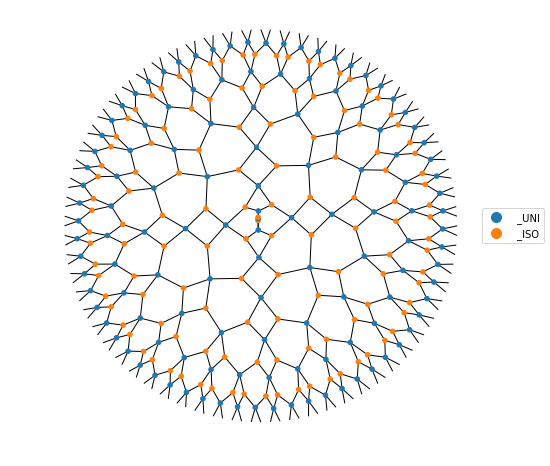

In [4]:
mera.graph(color=['_UNI', '_ISO'], **graph_opts)

It also tags each layer with ``'_LAYER2'`` etc.:

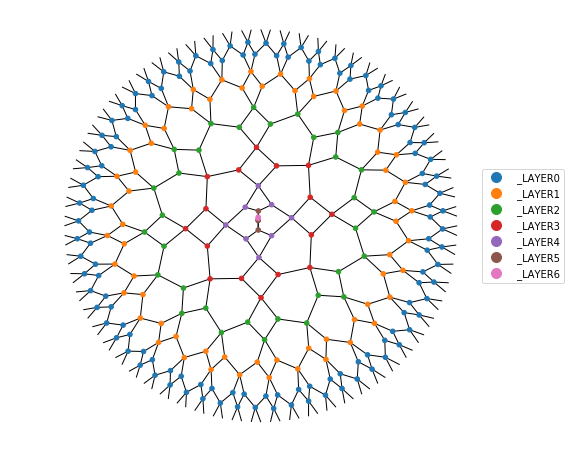

In [5]:
mera.graph(color=[f'_LAYER{i}' for i in range(7)], **graph_opts)

Finally, the site-tags of each initial tensor (``'I0'``, ``'I1'``, ``'I3'``, etc.) are propagated up through the isometries and unitaries, forming effective 'lightcones' for each site. Here, for example, we plot the lightcone of site 0, 40, and 80:

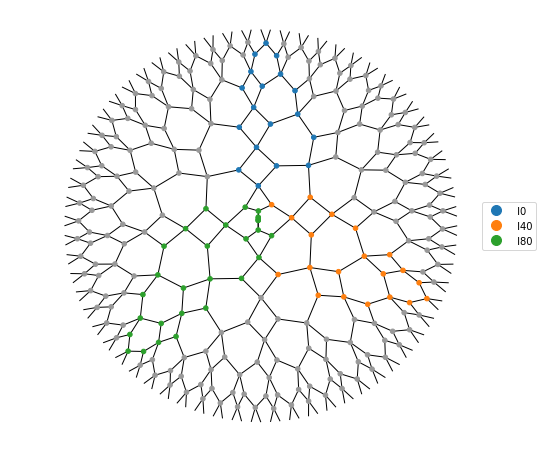

In [6]:
mera.graph(color=['I0', 'I40', 'I80'], **graph_opts)

Computing Local Quantities
----------------------------------------

In a MERA state, local quantities depend only on this lightcone. The way that ``quimb.tensor`` works supports this very naturally. Firstly, you can easily select all the tensors with site tag ``i``, i.e. the causal cone, with ``MERA.select(i)``:

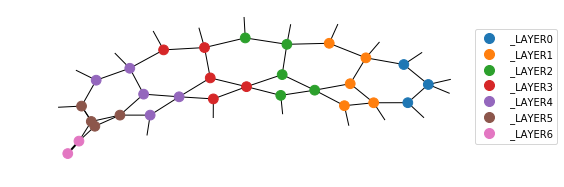

In [7]:
# select all tensors relevant for site-0
mera.select(0).graph(color=[f'_LAYER{i}' for i in range(7)])

Secondly, when combined with its conjugate network, all the dangling indices automatically match up. As an example, consider the state norm, but calculated for site 80 only:

In [8]:
nrm80 = mera.select(80).H  & mera.select(80)

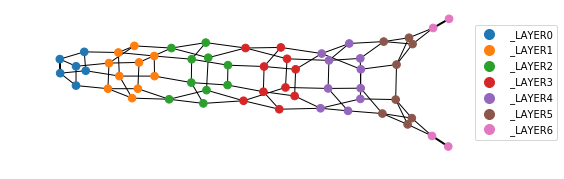

In [9]:
nrm80.graph(color=[f'_LAYER{i}' for i in range(7)])

We can contract this whole subnetwork efficiently to compute the actual value:

In [10]:
nrm80 ^ all

0.9999999999999983

As expected. Or consider we want to measure $\langle \psi | X_i Z_j | \psi \rangle$:

In [11]:
i, j = 50, 100
ij_tags = mera.site_tag(i), mera.site_tag(j)
ij_tags

('I50', 'I100')

Now we can select the subnetwork of tensors with *either* the site 50 or site 100 lightcone (and also conjugate to form $\langle \psi |$):

In [12]:
mera_ij_H = mera.select(ij_tags, which='any').H

For $X_i Z_j | \psi \rangle$ we'll first apply the X and Z operators. By default the gate operation propagates the site tags to the applied operators as well, or we could use ``contract=True`` to actively contract them into the MERA:

In [13]:
X = qu.pauli('X')
Z = qu.pauli('X')

XY_mera_ij = (
    mera
    .gate(X, i, inplace=False)
    .gate(Z, j, inplace=False)
    .select(ij_tags, which='any')
)

Now we can lazily form the tensor network of this expectation value:

In [14]:
exp_XZ_ij = (mera_ij_H & XY_mera_ij)

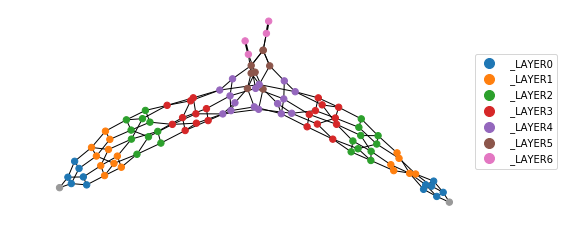

In [15]:
exp_XZ_ij.graph(color=[f'_LAYER{i}' for i in range(7)])

Which we can efficiently contract:

In [16]:
exp_XZ_ij ^ all

-0.015336575509217673

In [17]:
%%timeit
exp_XZ_ij ^ all

2.86 ms ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
# generate the 'bra' state
mera_H = mera.H.reindex_sites('b{}', range(20))

We again only need the tensors in the causal cones of these 20 sites:

In [19]:
# NB we have to slice *before* combining the subnetworks here.
#    this is because paired indices are mangled when joining
#    two networks -> only dangling indices are guranteed to 
#    retain their value
rho = (
    mera_H.select(slice(20), which='any') & 
    mera.select(slice(20), which='any')
)

We can see what this density operator looks like as a tensor network:

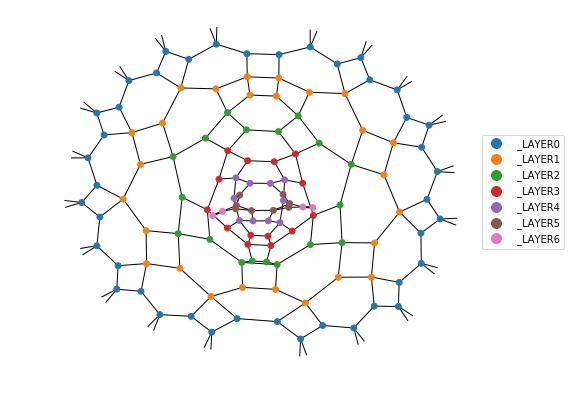

In [20]:
rho.graph(color=[f'_LAYER{i}' for i in range(7)])

Or we can plot the sites (note that each initial unitary is two sites, and later color tags take precedence, thus the 'every-other' coloring effect):

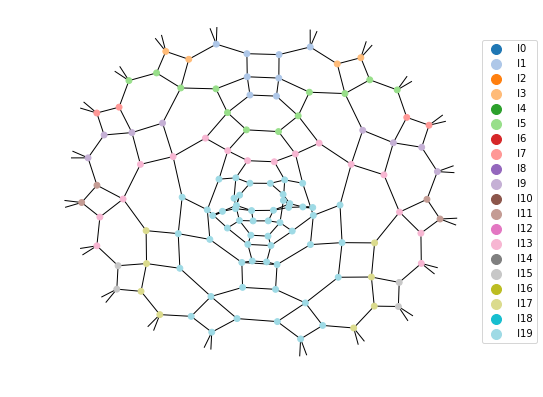

In [21]:
rho.graph(color=[f'I{i}' for i in range(20)])

This density matrix is too big to explicitly form (it would need $2^{40}$, about a trillion, elements).
On the other hand we can treat it as linear operator, in which case we only need to compute its action on
a vector of size $2^{20}$. This allows the computation of 'spectral' quantities of the form $\text{Tr}(f(\rho)$.

One such quantity is the entropy $-\text{Tr} \left( \rho \log_2 \rho \right)$:

In [22]:
# mark the indices as belonging to either the 'left' or 
#     'right' hand side of the effective operator
left_ix = [f'k{i}' for i in range(20)]
rght_ix = [f'b{i}' for i in range(20)]

# form the linear operator
rho_ab = rho.aslinearoperator(left_ix, rght_ix)
rho_ab

<1048576x1048576 TNLinearOperator with dtype=float64>

In [23]:
f = qu.xlogx
S =  - qu.approx_spectral_function(rho_ab, f, tol=0.02)
print("rho_entropy ~", S)

rho_entropy ~ 5.543219790611015


To compute a genuine entanglement measure we need a further small trick. Specifically, if we are computing the negativity between subsystem A and subsystem B, we can perform the [partial transpose](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion) simply by swapping subsystem B's 'left' indices for right indices. This creates a linear operator of $\rho_{AB}^{T_B}$, which we can compute the logarithmic negativity for, 
$\mathcal{E} = \log_2 \text{Tr} |\rho_{AB}^{T_B}|$:

In [24]:
# partition 20 spins in two
sysa = range(0, 10)
sysb = range(10, 20)

# k0, k1, k2, ... b10, b11, b12, ...
left_ix = [f'k{i}' for i in sysa] + [f'b{i}' for i in sysb]
# b0, b1, b2, ... k10, k11, k12, ...
rght_ix = [f'b{i}' for i in sysa] + [f'k{i}' for i in sysb]

rho_ab_pt = rho.aslinearoperator(left_ix, rght_ix)

Now we just to to take ``abs`` as the function $f$ and scale the result with $\log_2$:

In [25]:
f = abs
neg = qu.approx_spectral_function(rho_ab_pt, f, tol=0.02)
print("rho_ab logarithmic negativity ~", qu.log2(neg))

rho_ab logarithmic negativity ~ 1.6413581391824439
